# Titanic Data Analysis By Mehdi Jafari

## Introduction

This project is analyzing the demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. Here are the variables that I will look at:  
1- Socioeconomic status  
2- Being alone or with family   

I will try to answer the following questions:   

1- Did people's socioeconomic status help them to get into lifeboat?  
2- How did being with family affect their chance for survival?  
3- What is to co-relation between the survival and number of family members?  


In [1]:
%matplotlib inline 
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

titanic_df = pd.read_csv('titanic-data.csv')
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data Wrangling

Since count in the column 'Age' is different from other columns, there must be some rows in our dataset with invalid or null age which should be scraped from the dataset that will be used for the rest of this project.


In [2]:
titanic_df = titanic_df[titanic_df.Age > 0]

print len(titanic_df)

714


In [3]:

#lambda function for survival conversion 
SurvivalConversion = lambda survived: 'SURVIVED' if survived == 1 else 'DIED'

#lambda function to return 'With Family' if thet are traveling with their siblings, parents, partners or children 
WithFamilyConversion = lambda sibsp , parch: 'Alone'  if sibsp == 0 and parch == 0 else 'With Family'

#function to convert pClass value based on the documentation
def ConvertPClass(pclass):
    if pclass == 1:
        return 'Upper'
    elif pclass == 2:
        return 'Middle'
    elif pclass == 3:
        return 'Lower'
    else:
        return 'NA'

#returns number of family members on the board
def FamilyCount(sibsp, parch):
    return sibsp + parch

#standardize the value    
def StandardizeColumn(column, value):
    std = column.std()
    mean = column.mean()
    return (value - mean) / std

#adding comuted columns
titanic_df['SurvivedFactor'] = titanic_df['Survived'].apply(SurvivalConversion)
titanic_df['PclassFactor'] = titanic_df['Pclass'].apply(ConvertPClass)
titanic_df['WithFamily'] =  titanic_df.apply(lambda row: WithFamilyConversion(row['SibSp'], row['Parch']), axis=1)
titanic_df['FamilyCount'] = titanic_df.apply(lambda row: FamilyCount(row['SibSp'], row['Parch']), axis=1)
titanic_df['ScaledFamilyCount'] = (titanic_df['FamilyCount'] - titanic_df['FamilyCount'].mean()) / titanic_df['FamilyCount'].std(ddof=0)
titanic_df['ScaledAge'] = (titanic_df['Age'] - titanic_df['Age'].mean()) / titanic_df['Age'].std(ddof=0)

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SurvivedFactor,PclassFactor,WithFamily,FamilyCount,ScaledFamilyCount,ScaledAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,DIED,Lower,With Family,1,0.037783,-0.530377
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,SURVIVED,Upper,With Family,1,0.037783,0.571831
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,SURVIVED,Lower,Alone,0,-0.636641,-0.254825
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,SURVIVED,Upper,With Family,1,0.037783,0.365167
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,DIED,Lower,Alone,0,-0.636641,0.365167


## Exploration Phase


### Selected Variables Distribution

Let's start with exploring the destitution of our selected variables:


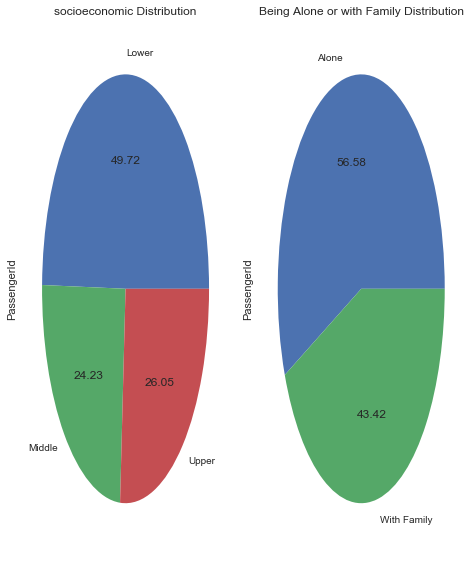

In [4]:
SocioEconomicDistribution = pd.Series(titanic_df.groupby(['PclassFactor']).count()['PassengerId'])
WithFamilyDistribution = pd.Series(titanic_df.groupby(['WithFamily']).count()['PassengerId'])

plt.close('all')
fig = plt.figure()

ax1 = plt.subplot2grid((1, 36), (0, 0), colspan=12)
ax2 = plt.subplot2grid((1, 36), (0, 12), colspan=12)


SocioEconomicDistribution.plot.pie(figsize=(10, 8),autopct='%.2f', title="socioeconomic Distribution", ax=ax1)
WithFamilyDistribution.plot.pie(figsize=(10, 8),autopct='%.2f', title="Being Alone or with Family Distribution", ax=ax2)

plt.tight_layout()

### 1- Did people's socioeconomic status help them to get into lifeboat?
As dipected in the follwing diagram, there could be a corelation between socio-economic status and the survival. About 70 percent of Upper class travelers survicved where as only 25 percent of lower class survived.


0    0.760563
1    0.520231
2    0.344086
dtype: float64


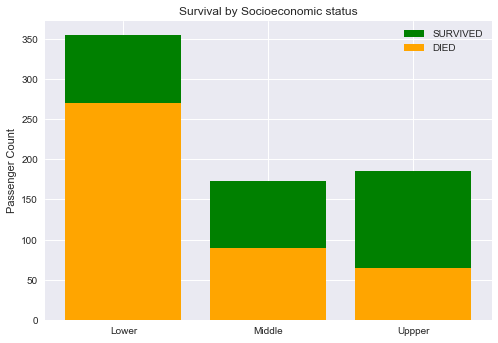

In [5]:
groups = [0,1,2] 
categoryCount = titanic_df.groupby(['PclassFactor']).count()['PassengerId']
survivalBreakdown = titanic_df.groupby(['SurvivedFactor','PclassFactor']).count()['PassengerId']
totalCount = (categoryCount['Lower'],
              categoryCount['Middle'],
              categoryCount['Upper'])
diedCount = (survivalBreakdown['DIED']['Lower'],
             survivalBreakdown['DIED']['Middle'],
             survivalBreakdown['DIED']['Upper'])

print pd.Series(diedCount)/pd.Series(totalCount)

p1 = plt.bar(groups, totalCount, align='center', color='green')
p2 = plt.bar(groups, diedCount, align='center', color='orange')

plt.xticks(groups, ('Lower','Middle','Uppper'))
plt.ylabel('Passenger Count')
plt.title('Survival by Socioeconomic status')
plt.legend((p1[0],p2[0]),('SURVIVED','DIED'))
plt.show()

### 2- How did being with family affect their chance for survival?
 As we can see in the diagram and percisely in the printed values they would have better chance to survice if they were travling with family. 

0    0.678218
1    0.483871
dtype: float64


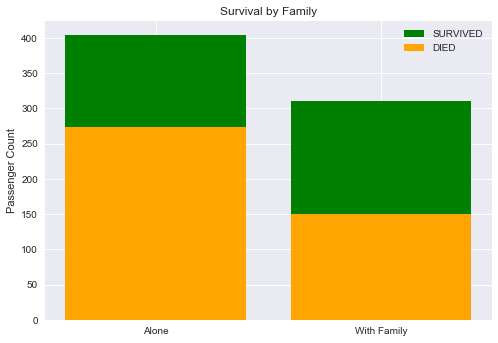

In [6]:
groups = [0,1] 
categoryCount = titanic_df.groupby(['WithFamily']).count()['PassengerId']
survivalBreakdown = titanic_df.groupby(['SurvivedFactor','WithFamily']).count()['PassengerId']
totalCount = (categoryCount['Alone'],categoryCount['With Family'])
diedCount = (survivalBreakdown['DIED']['Alone'],survivalBreakdown['DIED']['With Family'])

print pd.Series(diedCount)/pd.Series(totalCount)

p1 = plt.bar(groups, totalCount, align='center', color= 'green')
p2 = plt.bar(groups, diedCount, align='center',  color='orange')

plt.xticks(groups, ('Alone','With Family'))
plt.ylabel('Passenger Count')
plt.title('Survival by Family')
plt.legend((p1[0],p2[0]),('SURVIVED','DIED'))
plt.show()

### 3- What is to co-relation between the survival and number of family members?

As we can see in the following report, the calculated Pearson correlation coefficient value is 0.301913959192 which means there is not a strong correlation between survival and the number of family members on the RMS titanic.

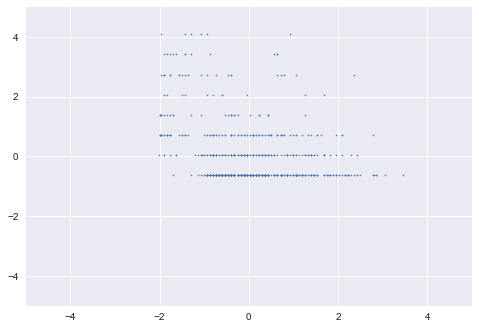

-0.301913959192


In [7]:
standardAgeMean = titanic_df['ScaledAge'].mean()
standardAgeStd = titanic_df['ScaledAge'].std()
lx = standardAgeMean-(5*standardAgeStd)
hx = standardAgeMean+(5*standardAgeStd)
standardFareMean = titanic_df['ScaledFamilyCount'].mean()
standardFareStd = titanic_df['ScaledFamilyCount'].std()
ly = standardFareMean-(5*standardFareStd)
hy = standardFareMean+(5*standardFareStd)
plt.scatter (titanic_df['ScaledAge'], titanic_df['ScaledFamilyCount'], s=1.5)
plt.axis([lx, hx, ly, hy])
plt.show()
print (titanic_df['ScaledAge'] * titanic_df['ScaledFamilyCount']).mean()

## Conclusions

We may say that people with higher socioeconomic status had a better chance for survival since 34 percent of high class passenger could not survive while 76 percent of lower class passengers died.  

We cannot clarify the reason behind it since we do not have enough information about their cabins and where they were located on the RMS ship. The reason could be higher class passengers had their cabin closer to the deck or lifeboats.  

In addition, we have showed in our sample that being with family affected passengers survival chance since 67% of passengers who were traveling alone could not survive while the same factor for people who were traveling with their family is around 48 percent.
